#### Inferences (example 03)

In [16]:
import memocell as me
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import pickle


stuff to mention maybe:
- MemoCell is Bayesian framework
- evidence values are future-proof, more models can be added later without recomputing previous models
- model probabilities (and Bayes factors) depend on the set of models
- model probs and Bayesian averaging allow to compute any statistic X (as in methods in paper)
- say that models/hypotheses that are not considered are given zero prior implicitly! (and are impossible to gain posterior consideration, no matter how strong the data would favor them)
- maybe add a small topology inference gimik: add a death reaction to the cell division process, should be some unneccesary additional complexity, so Bayesian inference automatically safeguard against overfitting
- ALSO add time values for selection (say there) if this error message occurs
- maybe for the model topology inference add a death/efflux additional reaction and probably see that it cannot be informed from one time point
- should also include: mean only fits (with mean only data)

maybe do one joint example "inference"?

with
- parameter estimation
- model probabilities
- waiting time inference
- topology inference

##### Parameter estimation and model probabilities

In [2]:
# the basic input to do inferences in memocell is: 
# memocell data object + list of memocell networks

# hence, first we load a memocell data object of a 
# process of cell divisions (see example 02)
# (we know the ground truth model)
data_10 = pickle.load(open('data_cell_div_t10.pickle', 'rb'))
# print(data_10) -> memocell.data.Data object

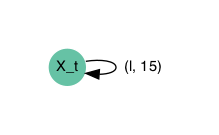

In [3]:
# here we define the list of networks and their respective 
# parameter settings for the inference

# make_net returns a memocell network for a cell division process 
# with broad or tight Erlang division times depending on substeps n
def make_net(n):
    net = me.Network(f'net_div_erl{n}')
    net.structure([{'start': 'X_t', 'end': 'X_t',
                 'rate_symbol': 'l',
                 'type': 'S -> S + S',
                 'reaction_steps': n}])
    return net

# we specify 7 different models with increasingly tight division times
nets = [make_net(n) for n in [1, 5, 10, 15, 20, 25, 30]]
# NOTE: nets[0] (n=1) contains the Markov model with 
# exponentially distributed division times
# NOTE: in the following "*len(nets)" is used to specify the 
# same settings for all networks

# these settings are known from simulations (see example 01)
# (initial values encode the single cell initial distribution)
variables = [{'X_t': ('X_t', )}]*len(nets)
initial_values_types = ['synchronous']*len(nets)
initial_values = [{('X_t',): 1.0, # mean (t=0)
                   ('X_t', 'X_t'): 0.0} # variance (t=0)
                 ]*len(nets)

# for each parameter, ranges have to be provided
# these specify uniform parameter prior distributions
theta_bounds = [{'l': (0.0, 0.5)}]*len(nets)

# specify time values for which the models are simulated in the inference
# NOTE: the first time value corresponds to the initial condition
# NOTE: if odeint gives a warning during the inference, you might 
# want to increase the "denseness" for better numerical integration
time_values = [np.linspace(0.0, 10.0, num=11)]*len(nets)

# plot the main layer of one of the networks
me.plots.net_main_plot(nets[3]);

# print(nets) -> list of memocell networks: [<memocell.network.Network at 0x7fc50b85a0d0>, ...]

In [4]:
# the memocell Bayesian inference based on nested sampling is run like this
# NOTE: this should not need much more than ≈7 minutes (in parallel mode)
est_res = me.selection.select_models(nets, variables,
                                    initial_values_types, initial_values,
                                    theta_bounds, data_10, sim_mean_only=False,
                                    time_values=time_values, parallel=True)

# NOTE: we strongly recommend to compute larger inferences via the terminal 
# and save and load estimation results with pickle

# NOTE: you may notice that larger networks (more hidden variables) take 
# longer to run; indeed, the moment equations to be solved scale quadratically 
# with the number of hidden variables; if mean-only inferences is all that is 
# needed use sim_mean_only=True to speed up the run time (≈1 minute total)

# NOTE: select_models is a wrapper for the estimation class, looping over 
# the list of models; hence est_res is a list of estimation objects
# print(est_res) -> [<memocell.estimation.Estimation at 0x7fc50bbddcd0>, ...]

  0%|          | 0/7 [00:00<?, ?it/s]

In [5]:
# we can read out logarithmic evidences from the estimation results
log_evids = np.array([est.bay_est_log_evidence for est in est_res])
print(log_evids)

# NOTE: evidence values are the prime output of nested sampling and also 
# the basis for Bayesian-averaged inferences over model sets in memocell; 
# evidences do not depend on the set of models / are internal to each model; 
# in this sense they provide future-proof information as more models can 
# be added later on, without recomputing the previous model set

# within some numerical error (est.bay_est_log_evidence_error), one should get:
# [-50.18391703 -10.29535513  -3.57241495  -2.9415347   -3.02019749
#  -3.25885459  -3.4702607 ]

[-50.19056971 -10.32280247  -3.56731998  -2.89355949  -3.08310264
  -3.33928902  -3.52702953]


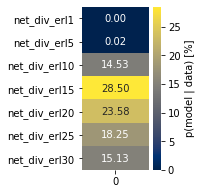

In [11]:
# posterior model probabilities are computed directly from the evidences
model_probs = me.selection.compute_model_probabilities(est_res)

# NOTE: the posterior probability and the Bayes factor of a given model 
# always depends on the overall used model set (in contrast to 
# model internal evidence values); in this sense, high model 
# probabilities might not mean much, if the overall model set is unable to 
# explain the data and/or not exhaustive

# we also read out the model names
net_names = [est.net.net_name for est in est_res]

# and plot the posterior model probabilities as a heatmap (in %)
plt.figure(figsize=(1.5,3))
df = pd.DataFrame(np.array([model_probs * 100.0]).T, index=net_names)
sns.heatmap(df, cmap='cividis', annot=True, fmt='.2f', cbar_kws={'label': 'p(model | data) [%]'});

# we might conclude:
# 1) the Markov model (net_div_erl1) is strongly rejected
# 2) the most favoured model is erl15; this was the ground truth model for 
#    these made up data, so memocell correctly recovers the underlying process
# 3) tighter division times (e.g., erl30) are less favoured, but are hard 
#    to reject: they are part of the minimal model set comprising at (least) 
#    95% cumulated posterior probability

In [7]:
# for larger inference runs the following code snippet 
# might be useful to look at the top models
sort_inds = np.array(- model_probs).argsort()
net_names_sorted = np.array(net_names)[sort_inds]
model_probs_sorted = np.array(model_probs)[sort_inds]
print(net_names_sorted)
print(model_probs_sorted)

# as indicated above, one can obtain a top model set by
# (minimal model set with >95% cumulated posterior)
num_top_models = model_probs_sorted.cumsum().searchsorted(0.95) + 1
print(num_top_models)
# -> 5, i.e. the first 5 models have > 95% posterior
# (rejecting net_div_erl1 and net_div_erl5)

['net_div_erl15' 'net_div_erl20' 'net_div_erl25' 'net_div_erl30'
 'net_div_erl10' 'net_div_erl5' 'net_div_erl1']
[2.84995901e-01 2.35787659e-01 1.82499103e-01 1.51260687e-01
 1.45287465e-01 1.69184036e-04 8.20366773e-22]
5


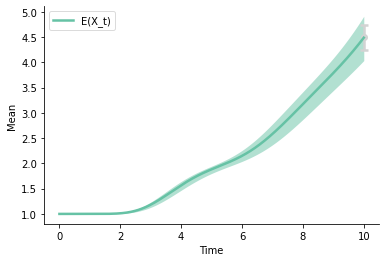

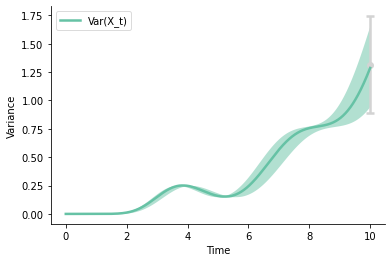

In [8]:
# we can inspect the model fits; the best model of 
# the tested model set can explain the data well
# (it was the data generating model)
est_i = net_names.index('net_div_erl15')

me.plots.est_bestfit_mean_plot(est_res[est_i])
me.plots.est_bestfit_variance_plot(est_res[est_i]);

# NOTE: the bands below are 95% credible intervals of 
# posterior model simulations; the best-fit line is the 
# median (50th percentile) of posterior model simulations

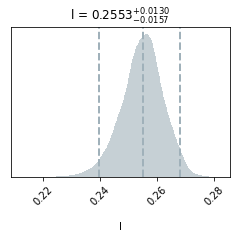

In [9]:
# parameter estimation:
# the in silico data was produced with l=0.255,
# so memocell recovers the underlying process
me.plots.est_corner_kernel_plot(est_res[est_i]);

# NOTE: the dashed lines indicate 95% credible 
# interval (by 2.5th and 97.5th percentiles) and 
# median (50th percentile)

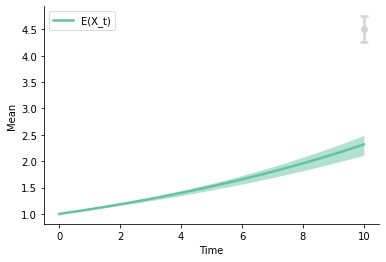

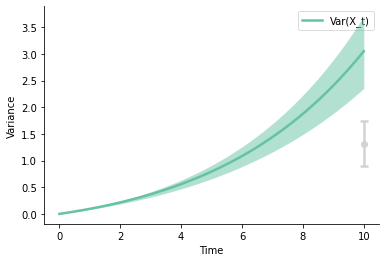

In [10]:
# why are other models worse? a look at model fits

# the markov model / exponential division times (CV=1)
# creates a too large variability, so that mean and 
# variance of the data cannot be explained simultaneously
est_i = net_names.index('net_div_erl1')
me.plots.est_bestfit_mean_plot(est_res[est_i])
me.plots.est_bestfit_variance_plot(est_res[est_i]);

# NOTE: for the erl30 models and higher, the effect is 
# exactly opposite; they create a too low variability

##### Inference of waiting time distributions

In [12]:
est_res

In [17]:
def waiting_time_distr_samples(x, res, samples, time_max, mprior):
    model_probs = me.selection.compute_model_probabilities(res, mprior=mprior)

    # set general x values
    y = np.zeros((x.shape[0], samples))

    # for checking set a counter
    model_type_counts = np.zeros((7,))

    for i in range(samples):
        # get random model according to p(M|D)
        model_rand = np.random.choice(range(len(model_probs)), p=model_probs, replace=True)
        est = res[model_rand]

        model_type_counts[model_rand] += 1

        # get random theta according to p(theta|M, D)
        inds = np.array(range(0, est.bay_est_samples_weighted.shape[0]))
        theta_ind = np.random.choice(inds, replace=True)
        theta = est.bay_est_samples_weighted[theta_ind, :]

        
        module_id = 0 # TODO make a note here with below
        theta_id = 0 # TODO make a note here with below
        
        # compute Erlang/Gamma parameters for the division reaction
        theta_shape = est.net.net_modules[module_id]['module_steps']
        theta_scale = 1.0/(theta[theta_id]*theta_shape)

        density = stats.gamma.pdf(x, a=theta_shape, scale=theta_scale)
        y[:, i] = density
    
    # this shows how often each model was drawn
    print(model_type_counts)
    return y

In [30]:
# idea to compute "credible bands" for better visualisation
samples = 1000
time_max = 10.0
x = np.linspace(0.0, time_max, num=200)
mprior = None # if None, a uniform model prior is used

y = waiting_time_distr_samples(x, est_res, samples, time_max, mprior)

[  0.   0. 138. 270. 240. 199. 153.]


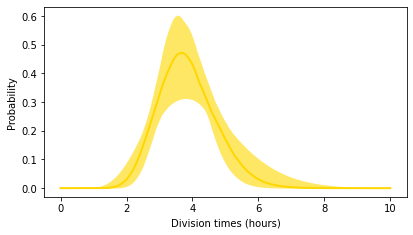

In [31]:
y_95_lower = np.percentile(y, 2.5, axis=1)
y_median = np.percentile(y, 50.0, axis=1)
y_95_upper = np.percentile(y, 97.5, axis=1)

plt.figure(figsize=(6.5, 3.5))
plt.fill_between(x, y_95_lower, y_median, color='gold', alpha=0.6, linewidth=0.0, zorder=100)
plt.fill_between(x, y_median, y_95_upper, color='gold', alpha=0.6, linewidth=0.0, zorder=100)
plt.plot(x, y_median, color='gold', lw=2, zorder=200)

plt.ylabel('Probability')
plt.xlabel('Division times (hours)');

In [13]:
est_res[0].net.net_modules

[{'module': 'module_0',
  'start-end': ('X_t', 'X_t'),
  'start-end_ident': ('Z_0', 'Z_0'),
  'sym_rate': 'l',
  'sym_rate_ident': 'theta_0',
  'type': 'S -> S + S',
  'module_steps': 1}]

In [ ]:
# NOTE: maybe just put this code down below and say the rest
# read out the respective Erlang channels of a phase-type reaction
n_d1 = est.net.net_modules[0]['module_steps']
n_d2 = est.net.net_modules[1]['module_steps']
d1 = theta[0]
d2 = theta[1]

# obtain the phase-type density with utils methods
alpha, S = me.utils.phase_type_from_parallel_erlang2(d1, d2, n_d1, n_d2)
density = me.utils.phase_type_pdf(alpha, S, x)

In [5]:
# TODO: module_id and theta_id have to be known in advance for a reaction of interest

# TODO: maybe mention the X formula here

# TODO: also explain how to read out steps numbers from more complicated models
# ALSO: mention example 01 where phase-type utils was shown, which would be required then to get pdf

# TODO: maybe add a separate PH model fit to the Erlang data here? 
# what would happen? if nothing is inferred anymore, maybe don't show it
# would however help maybe to show the read-out notation

In [ ]:
def waiting_time_distr_samples_div(x, res, samples, time_max, mprior):
    model_probs = me.selection.compute_model_probabilities(res, mprior=mprior)

    # set general x values
    y = np.zeros((x.shape[0], samples))

    # for checking set a counter
    model_type_counts = np.zeros((4,))

    for i in range(samples):
        # get random model according to p(M|D)
        model_rand = np.random.choice(range(len(model_probs)), p=model_probs, replace=True)
        est = res[model_rand]

        # decide whether phase type or markov/erlang model
        # par 3 model
        if 'par3_' in est.net.net_name:
            model_type_counts[3] += 1

            # get random theta according to p(theta|M, D)
            inds = np.array(range(0, est.bay_est_samples_weighted.shape[0]))
            theta_ind = np.random.choice(inds, replace=True)
            theta = est.bay_est_samples_weighted[theta_ind, :]

            # compute Gamma parameters
            ### division reaction ###
            theta_shape = est.net.net_modules[3]['module_steps']
            theta_scale = 1.0/(theta[3]*theta_shape)

            density = stats.gamma.pdf(x, a=theta_shape, scale=theta_scale)

        # par 2 model
        elif 'par2_' in est.net.net_name:
            model_type_counts[2] += 1

            # get random theta according to p(theta|M, D)
            inds = np.array(range(0, est.bay_est_samples_weighted.shape[0]))
            theta_ind = np.random.choice(inds, replace=True)
            theta = est.bay_est_samples_weighted[theta_ind, :]

            # compute Gamma parameters
            ### division reaction ###
            theta_shape = est.net.net_modules[2]['module_steps']
            theta_scale = 1.0/(theta[2]*theta_shape)

            density = stats.gamma.pdf(x, a=theta_shape, scale=theta_scale)

        # par1+i model (identified by d_ni symbolic rate)
        elif 'd_ni' in est.net.net_rates_identifier.values():
            model_type_counts[1] += 1

            # get random theta according to p(theta|M, D)
            inds = np.array(range(0, est.bay_est_samples_weighted.shape[0]))
            theta_ind = np.random.choice(inds, replace=True)
            theta = est.bay_est_samples_weighted[theta_ind, :]

            # compute Gamma parameters
            ### division reaction ###
            theta_shape = est.net.net_modules[2]['module_steps']
            theta_scale = 1.0/(theta[2]*theta_shape)

            density = stats.gamma.pdf(x, a=theta_shape, scale=theta_scale)

        # markov/erlang model
        else:
            model_type_counts[0] += 1

            # get random theta according to p(theta|M, D)
            inds = np.array(range(0, est.bay_est_samples_weighted.shape[0]))
            theta_ind = np.random.choice(inds, replace=True)
            theta = est.bay_est_samples_weighted[theta_ind, :]

            # compute Gamma parameters
            ### division reaction ###
            theta_shape = est.net.net_modules[1]['module_steps']
            theta_scale = 1.0/(theta[1]*theta_shape)

            density = stats.gamma.pdf(x, a=theta_shape, scale=theta_scale)
        y[:, i] = density

    print(model_type_counts)
    return y

##### Inference of model topologies

In [2]:
# TODO: add note: 
# topologies means connectivity of the models beyond the structure to implement waiting times